In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
import pymc3 as pm
import arviz as az
import sunode
import sunode.wrappers.as_theano
from pymc3.ode import DifferentialEquation
import theano.tensor as tt
import theano
import datetime
import shelve
from datetime import datetime as dt
import time
np.random.seed(0)

In [8]:
class COVID_data():
 
    def __init__(self, country='US', Population = 328.2e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        path_to_save = ''
 
        # ------------------------- Country for inference -------------------
 
        self.country = country
        self.N = Population   # Population of the country
                         # Germany - 83.7e6
                         # US - 328.2e6
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin  #Take the data until yesterday
        self.data_end = data_end
        self.num_days_to_predict = 14
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_country = confirmed_cases.loc[confirmed_cases["Country/Region"] == country]
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print("------------ Cases for selected period ----------- ",self.cases_obs)
 
        date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == self.country, data_begin:data_end].columns[-1]
        month, day, year = map(int,date_data_end.split('/'))
        date_data_end = datetime.date(year+2000, month, day)
        date_today = date_data_end + datetime.timedelta(days=1)
        print("------------- Cases yesterday ({}): {} and day before yesterday: {} ------------".format(date_data_end.isoformat(), *self.cases_obs[:-3:-1]))
        self.num_days = len(self.cases_obs)
 
        day_before_start = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=-1)
        day_before_start_cases = np.array(self.cases_country.loc[:, day_before_start.strftime('%-m/%-d/%-y')])
        print("------------ Day before start and cases for that date ------------", day_before_start, day_before_start_cases)
        future_days_begin = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=1)
        future_days_end = future_days_begin + datetime.timedelta(days=self.num_days_to_predict)
        self.future_days_begin_s = future_days_begin.strftime('%-m/%-d/%-y')
        self.future_days_end_s = future_days_end.strftime('%-m/%-d/%-y')
        print("------------- Future date begin and end -------------",self.future_days_begin_s, self.future_days_end_s)
        self.future_days = np.array(self.cases_country.loc[:, self.future_days_begin_s : self.future_days_end_s])[0]
        print("------------- Future days cases ------------", self.future_days)
 
 
class SIR_model():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_non_normalized(self, y, t, p):
        ds = -p[0] * y[0] * y[1] /self.covid_data.N
        di = p[0] * y[0] * y[1] / self.covid_data.N  -  p[1] * y[1]
        return [ds, di]
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
 
        # SIR model
        self.sir_model_non_normalized = DifferentialEquation(
            func=self.SIR_non_normalized,
            times=self.time_range[1:],
            n_states=2,
            n_theta=2,
            t0=0)
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', likelihood['sigma'], shape=1)
            lam = pm.Lognormal('lambda', prior['lam'], prior['lambda_std'])
            mu = pm.Lognormal('mu', prior['mu'], prior['mu_std'])
 
            res = self.sir_model_non_normalized(y0=[self.S0, self.I0], theta=[lam, mu])
 
            if(likelihood['distribution'] == 'lognormal'):
                Y = pm.Lognormal('Y', mu=pm.math.log(res.take(0, axis=1)), sigma=sigma, observed=self.covid_data.cases_obs[1:])
            else:
                Y = pm.StudentT( "Y",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res.take(0, axis=1),     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=cases_obs[1:]
                        )
            trace = pm.sample(self.n_samples, tune=self.n_tune, target_accept=0.9, 
                              cores=1#2 for some reason, it isnt working on 2 cores
                             )
            data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(data, round_to=2, hdi_prob=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
 
 
 
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam_mu = np.log(self.prior['lam']) + self.prior['lambda_std']**2
            mu_mu = np.log(self.prior['mu']) + self.prior['mu_std']**2
            lam = pm.Lognormal('lambda', lam_mu , self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', mu_mu, self.prior['mu_std'])           # 1.5, 1.5
 
            res, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
            y0={
            # The initial conditions of the ode. Each variable
            # needs to specify a theano or numpy variable and a shape.
            # This dict can be nested.
                'S': (self.S_init, ()),
                'I': (self.I_init, ()),},
            params={
            # Each parameter of the ode. sunode will only compute derivatives
            # with respect to theano variables. The shape needs to be specified
            # as well. It it infered automatically for numpy variables.
            # This dict can be nested.
                'lam': (lam, ()),
                'mu': (mu, ()),
                '_dummy': (np.array(1.), ())},
            # A functions that computes the right-hand-side of the ode using
            # sympy variables.
            rhs=self.SIR_sunode,
            # The time points where we want to access the solution
            tvals=self.time_range,
            t0=self.time_range[0]
            )
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
 
            theano.printing.Print('S')(res['S'])
            print('Problem',problem)
            print('Solver',solver)
 
            R = 1 - (res['I'] + res['S'])
            #S = 1 - (res['I'][1:])
            #theano.printing.Print('R')(R)
            R0 = pm.Deterministic('R0',lam/mu)
 
            step = pm.Metropolis()
            trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4, cores=4)
            data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(data, round_to=2, point_estimate='mode', credible_interval=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
        
        fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # Add title
        fig.update_layout(title_text='Curve and Rug Plot')
        fig.update_xaxes(range=[0,7])
              
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
        return(fig)
 
 
 

------------ Cases for selected period -----------  [3252949 3311373 3370303 3438354 3506444 3582310 3654546 3717082 3777538
 3839645]
------------- Cases yesterday (2020-07-20): 3839645 and day before yesterday: 3777538 ------------
------------ Day before start and cases for that date ------------ 2020-07-19 00:00:00 [3777538]
------------- Future date begin and end ------------- 7/21/20 8/4/20
------------- Future days cases ------------ [3904106 3974685 4043130 4116449 4181402 4236218 4293001 4359413 4431286
 4498752 4567464 4623665 4669233 4714734 4773508]


<ipython-input-8-7eb3781a1f11>:108: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.n_samples, tune=self.n_tune, target_accept=0.9,
Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, lambda, sigma]


Sampling 2 chains for 10 tune and 20 draw iterations (20 + 40 draws total) took 50 seconds.
/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/opt/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


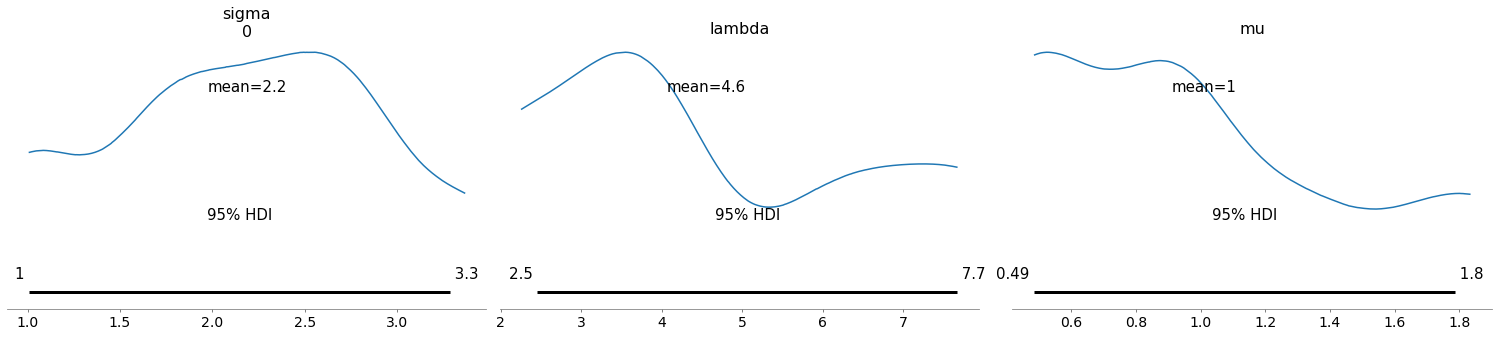

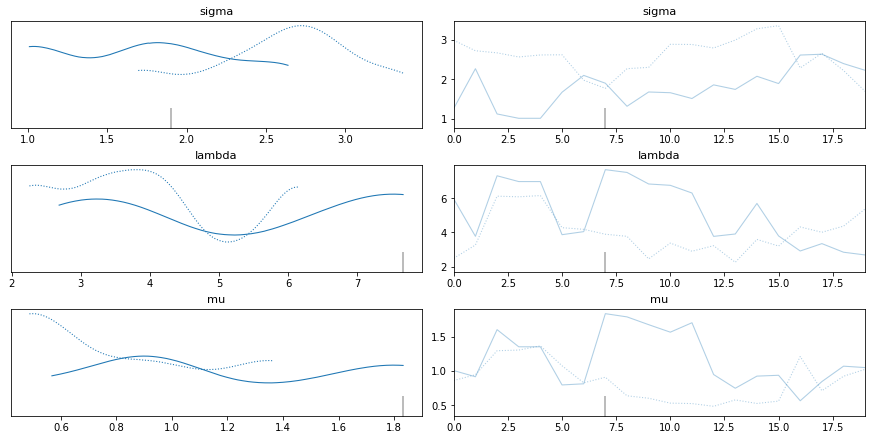

In [9]:
# -------- Usage --------#
covid_obj = COVID_data('US', Population=328.2e6)
covid_obj.get_dates(data_begin='7/11/20', data_end='7/20/20')
sir_model = SIR_model(covid_obj)
likelihood = {'distribution': 'lognormal', 'sigma': 2}
prior= {'lam': 0.4, 'mu': 1/8, 'lambda_std': 0.5, 'mu_std': 0.5 }
sir_model.run_SIR_model(n_samples=20, n_tune=10, likelihood=likelihood, prior=prior)